My ideal is to implement a function that can equivalently does two things
- align to hop
- window around hop

In [1]:
import shnitsel as st
import shnitsel.xarray

import xarray as xr
xr.set_options(
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_attrs=False
)

In [2]:
from shnitsel.data.tree import tree_to_frames
dt = st.io.read('tut_data/traj_I02.nc', kind='shnitsel')
frames = tree_to_frames(dt['/I02'])
frames

<xarray.Dataset> Size: 6MB
Dimensions:                (state: 3, frame: 6452, atom: 14, direction: 3,
                            statecomb: 3, full_statecomb: 6, trajid_: 16)
Coordinates: (24)
Data variables: (9)
Attributes: (6)

In [3]:
frames.st.hops([(1, 2), (2, 1)])

<xarray.Dataset> Size: 15kB
Dimensions:              (state: 3, frame: 16, atom: 14, direction: 3,
                          statecomb: 3, full_statecomb: 6)
Coordinates: (20)
Data variables: (9)
Attributes: (6)

The function `focus_hops` finds all hops matching the given hop types, even if
multiple occur in the same directory.
Good for investigating what happens near a hop.

In [4]:
focussed = frames.st.focus_hops([(2, 1)], slice(-5, 5))
focussed

<xarray.Dataset> Size: 260kB
Dimensions:              (hop: 14, state: 3, hop_time: 21, atom: 14,
                          direction: 3, statecomb: 3, full_statecomb: 6)
Coordinates: (21)
Dimensions without coordinates: hop
Data variables: (9)
Attributes: (6)

In [5]:
focussed.atXYZ

<xarray.DataArray 'atXYZ' (hop: 14, atom: 14, direction: 3, hop_time: 21)> Size: 49kB
array([[[[-4.57945108e+00, -4.58142519e+00, -4.58313227e+00, ...,
          -4.47788763e+00, -4.46927214e+00, -4.46194553e+00],
         [-1.36316374e-01, -1.36219025e-01, -1.35436282e-01, ...,
          -8.07348788e-02, -7.43500963e-02, -6.74343333e-02],
         [-3.19070041e-01, -3.17324311e-01, -3.14840734e-01, ...,
          -2.60751992e-01, -2.56775945e-01, -2.52404928e-01]],

        [[-3.85020041e+00, -3.85131121e+00, -3.84896970e+00, ...,
          -3.93703175e+00, -3.94495034e+00, -3.94973540e+00],
         [-1.74222744e+00, -1.74444437e+00, -1.75080681e+00, ...,
          -1.36018407e+00, -1.32152367e+00, -1.28846562e+00],
         [-1.19339299e+00, -1.22193527e+00, -1.25522685e+00, ...,
          -1.64555228e+00, -1.66890121e+00, -1.69848859e+00]],

        [[-6.59558821e+00, -6.60140228e+00, -6.60207224e+00, ...,
          -6.51451731e+00, -6.50480938e+00, -6.49201345e+00],
         [-4.17649150e-01, -4.01932627e-01, -3.82003754e-01, ...,
           1.80127680e-01,  2.05688447e-01,  2.26965100e-01],
         [ 2.45481029e-01,  2.32803583e-01,  2.19349086e-01, ...,
           1.26105666e-01,  1.27640292e-01,  1.29334465e-01]],
...
           4.82851315e+00,  4.82588577e+00,  4.82209969e+00],
         [ 6.07730389e+00,  6.07646656e+00,  6.07733107e+00, ...,
           6.12121916e+00,  6.12555027e+00,  6.13066292e+00],
         [ 1.26488268e+00,  1.27698517e+00,  1.28850198e+00, ...,
           1.41275716e+00,  1.41370320e+00,  1.41338789e+00]],

        [[ 4.64101744e+00,  4.60208225e+00,  4.56745243e+00, ...,
           4.17584896e+00,  4.16914129e+00,  4.16565609e+00],
         [ 8.05795479e+00,  8.03545189e+00,  7.99973774e+00, ...,
           8.04002190e+00,  8.02219486e+00,  7.99000072e+00],
         [ 8.68136764e-01,  8.68838727e-01,  8.72401953e-01, ...,
           8.19042683e-01,  8.27186227e-01,  8.39617550e-01]],

        [[ 6.49339199e+00,  6.46232891e+00,  6.44759607e+00, ...,
           6.74232578e+00,  6.66534901e+00,  6.59781456e+00],
         [ 5.39215708e+00,  5.44205761e+00,  5.49031353e+00, ...,
           6.17319489e+00,  6.21634722e+00,  6.25625134e+00],
         [ 1.95939910e+00,  1.89179623e+00,  1.83126116e+00, ...,
           1.41044378e+00,  1.40692425e+00,  1.40828240e+00]]]],
      shape=(14, 14, 3, 21), dtype=float32)
Coordinates: (11)
Dimensions without coordinates: hop
Attributes: (4)

In [ ]:
(focussed.atXYZ
    # rename to expected
    .swap_dims({'hop': 'trajid'})
    .drop_vars(['time'])
    .rename({'hop_time': 'time'})
    .stack({'frame': ['trajid', 'time']})
    
    .st.kabsch()
    .st.trajs3Dgrid()
)

The function `assign_hop_time` just adds a coordinate along the `frame` dimension.  
Good for representing each trajectory as centered around a single hop.

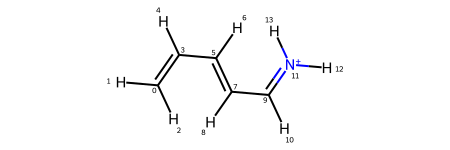

In [7]:
frames.assign_attrs(charge=1).st.default_mol()
frames.atXYZ.isel(frame=1).st.to_mol(atomNote=True, charge=1)

<Axes: xlabel='time', ylabel='$\\varphi_{3,5,7,9}$ / °'>

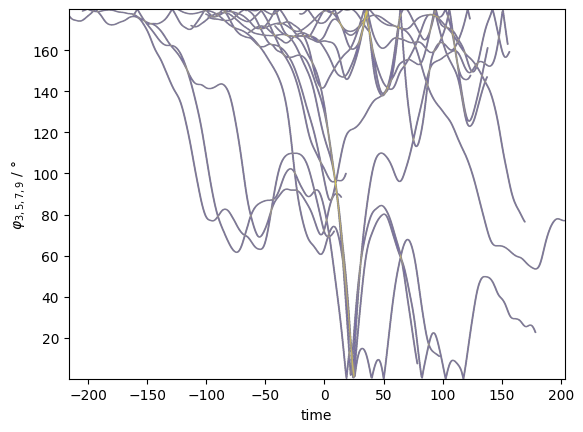

In [8]:
from shnitsel.vis.plot.time import timeplot
(frames.st.assign_hop_time()['atXYZ']
    .st.dihedral(3, 5, 7, 9, deg=True)
    # rename to expected
    .reset_index('frame').drop_vars('time').rename({'hop_time': 'time'})
    
    .pipe(timeplot, trajs='shade')
)

[<Axes: title={'center': 'S0'}, xlabel='time', ylabel='Absolute energy / Hartree'>,
 <Axes: title={'center': 'S1'}, xlabel='time', ylabel='Absolute energy / Hartree'>,
 <Axes: title={'center': 'S2'}, xlabel='time', ylabel='Absolute energy / Hartree'>]

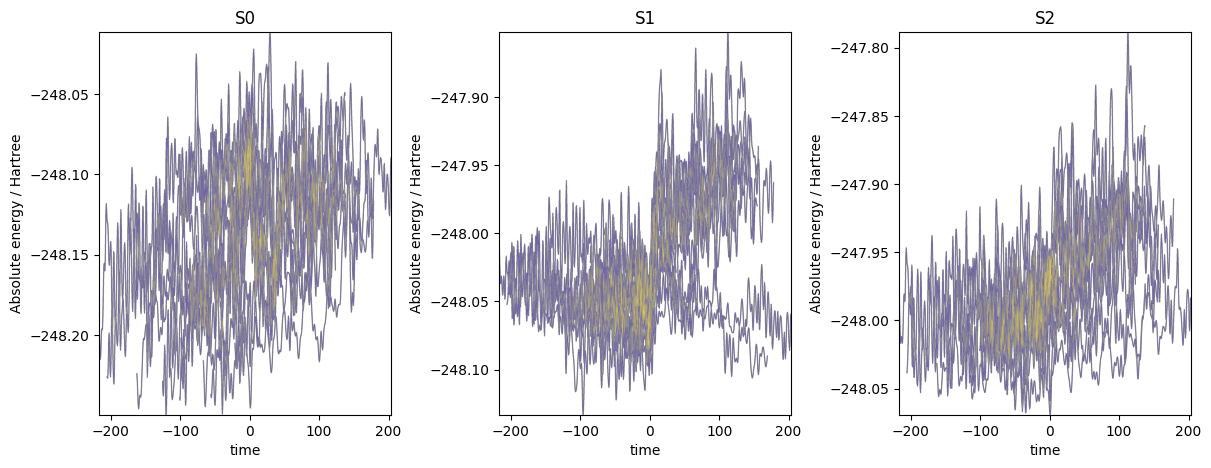

In [9]:
from shnitsel.vis.plot.time import timeplot
(frames.st.assign_hop_time()['energy']
    # rename to expected
    .reset_index('frame')
    .drop_vars('time')
    .rename({'hop_time': 'time'})
    
    .pipe(timeplot, trajs='shade')
)